In [1]:
#import dependecies
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the tools and libraries

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Models from Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [3]:
# Import the data
df = pd.read_csv('../input/heart-disease-dataset/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


### Exploratory Data Analysis


In [4]:
# Check the shape of the dataset

print("Number of rows in the dataset: ", df.shape[0])
print("Number of columns in the dataset: ", df.shape[1])

Number of rows in the dataset:  1025
Number of columns in the dataset:  14


The number of subjects with heart disease:  526
The number of subjects without heart disease:  499


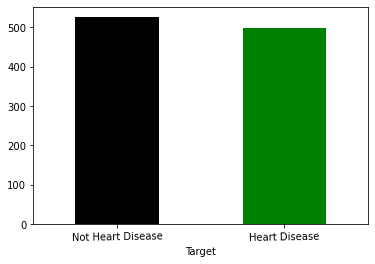

In [5]:
# How many of each class are there?
df.target.value_counts().plot(kind='bar',
                              xlabel='Target',
                              color=['black', 'green']);
plt.xticks([1, 0], ["Heart Disease", "Not Heart Disease"], rotation=1);

print("The number of subjects with heart disease: ", len(df[df['target'] == 1]))
print("The number of subjects without heart disease: ", len(df[df['target'] == 0]))

In [6]:
# Check for any null values
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

# Heart Disease Frequency According to Sex

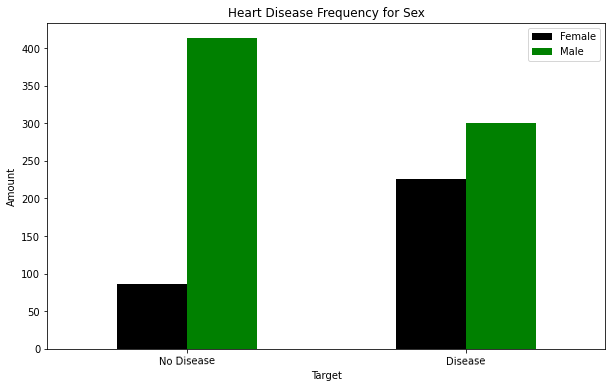

In [7]:
# Create a plot of a crosstab of the Sex and Target columns
pd.crosstab(df.target, df.sex).plot(kind='bar',
                                    figsize=(10, 6),
                                    color=['black', 'green'])
plt.title("Heart Disease Frequency for Sex")
plt.xlabel("Target")
plt.ylabel("Amount")
plt.legend(["Female", "Male"])
plt.xticks([0, 1], ["No Disease", "Disease"], rotation=1);


# Age vs. Max Heart Rate

Now we'll create a scatter plot to show patterns between the maximum heart rate of subjects against their age.

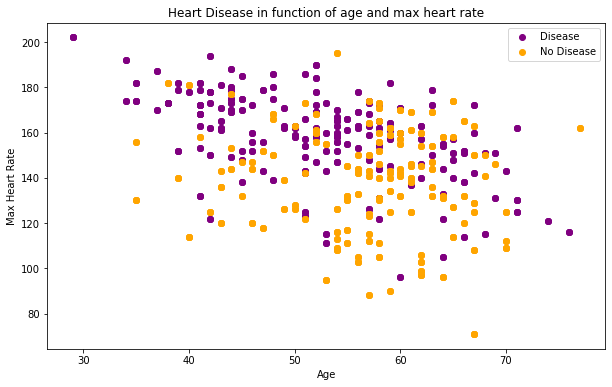

In [8]:
# Create a figure
plt.figure(figsize=(10, 6))

# Scatter with positive examples
plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
            color='purple')
# Scatter with negative examples
plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            color='orange')
# Add title, labels and legend
plt.title("Heart Disease in function of age and max heart rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Disease", "No Disease"]);

In [9]:
# Perhaps now we can drop all examples of subjects with age < 40 and > 70 to deal with outliers we can see in the above scatter plot.

print("Number of subjects under 40 years old: ", len(df.loc[df['age'] < 40]))
print("Number of subjects over 70 years old: ", len (df.loc[df["age"] > 70]))

Number of subjects under 40 years old:  57
Number of subjects over 70 years old:  20


In [10]:
# Drop the outliers
under_40 = df[df['age']<40].index
over_70 = df[df['age']>70].index

df.drop(under_40, inplace=True)
df.drop(over_70, inplace=True)

In [11]:
# Check that the outliers have been removed

print("Number of subjects under 40 years old: ", len(df.loc[df['age'] < 40]))
print("Number of subjects over 70 years old: ", len (df.loc[df["age"] > 70]))

Number of subjects under 40 years old:  0
Number of subjects over 70 years old:  0


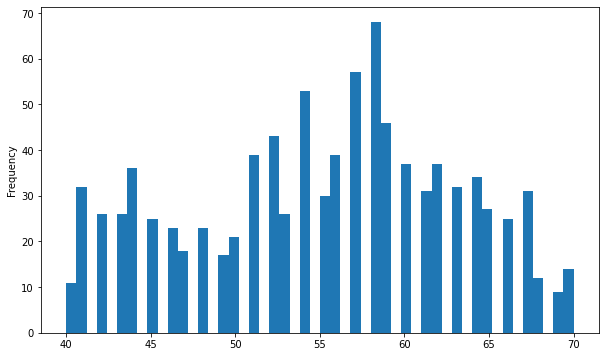

In [12]:
# Check the distribution of the modified Dataframe
df.age.plot.hist(figsize=(10, 6),
                 bins=50);

# Heart Disease Frequency per Chest Pain Type

cp = chest pain type
* 0: Typical Angina: Chest pain related to the heart
* 1: Atypical angina: Chest pain not related to the heart
* 2: Non-Anginal pain: Typically esophageal spasms(not heart related)
* 3: Asymptomatic: Chest pain not showing signs of disease

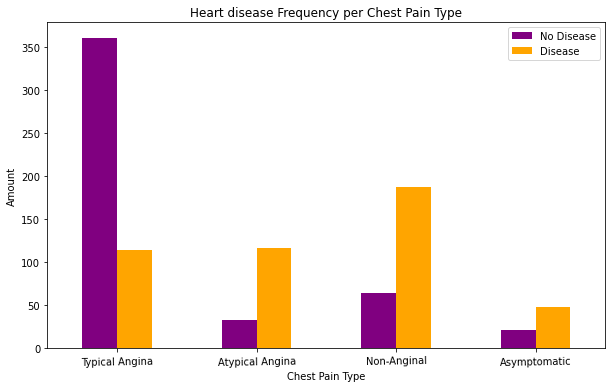

In [13]:
# Creat a plot of the crosstab of chest pain types against the target labels

pd.crosstab(df.cp, df.target).plot(kind='bar',
                                   figsize=(10, 6),
                                   color=['purple', 'orange'])
plt.title("Heart disease Frequency per Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Amount")
plt.legend(["No Disease", "Disease"])
plt.xticks([0, 1, 2, 3], ['Typical Angina', 'Atypical Angina', 'Non-Anginal', 'Asymptomatic'], rotation=1);

## Let's do one more visualization with a correlation matrix.


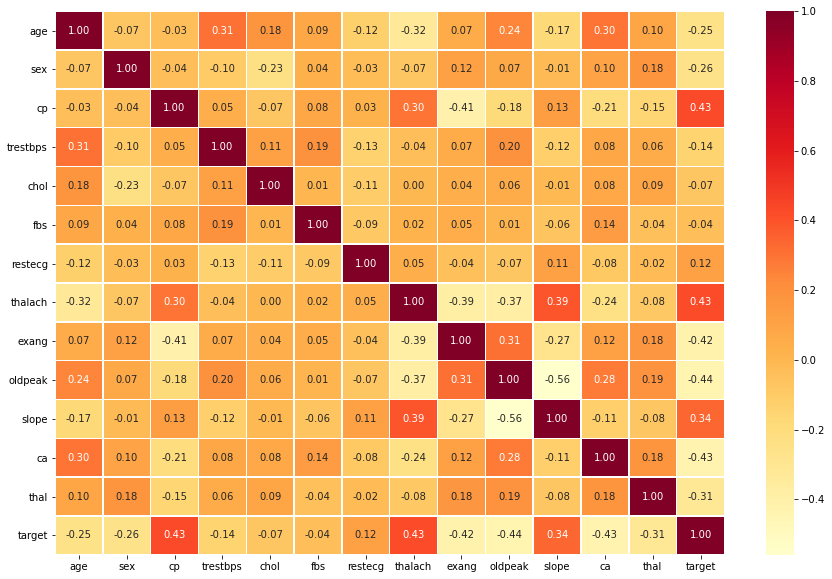

In [14]:
# Instantiate the correlation matrix
corr_mat = df.corr()

# Set up the figure
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_mat,
                 annot=True,
                 linewidths=0.5,
                 fmt='.2f',
                 cmap='YlOrRd');

# Modelling

In [15]:
# split data into X & y

X = df.drop('target', axis=1)
y = df.target

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape,X_test.shape, y_train.shape, y_test.shape

((758, 13), (190, 13), (758,), (190,))

## We're going to try 5 differnent models from Sklearn

* Logistic Regression
* KNearest Neighbors
* RandomForestClassifier
* Linear SVC
* SVC

In [16]:
# Put the models in a Python dictionary
models = {
          'Logistic Regression': LogisticRegression(),
          'KNN': KNeighborsClassifier(),
          'Random Forest Classifier': RandomForestClassifier(),
          'Linear SVC': LinearSVC(),
          'SVC': SVC()
         }

# Create a function to fit and score the models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models: a dict of different Sklearn models
    X_train: training data(no labels)
    X_test: testing data(no labels)
    y_train: training labels
    y_test: testing labels
    '''
    # Set up a random seed
    np.random.seed(42)

    # Create another dictionary to store model scores
    model_scores = {}
    # Loop through the models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append to 'model_scores'
        model_scores[name] = model.score(X_test, y_test)
    return model_scores
    


{'Logistic Regression': 0.8421052631578947,
 'KNN': 0.7157894736842105,
 'Random Forest Classifier': 1.0,
 'Linear SVC': 0.5684210526315789,
 'SVC': 0.7421052631578947}

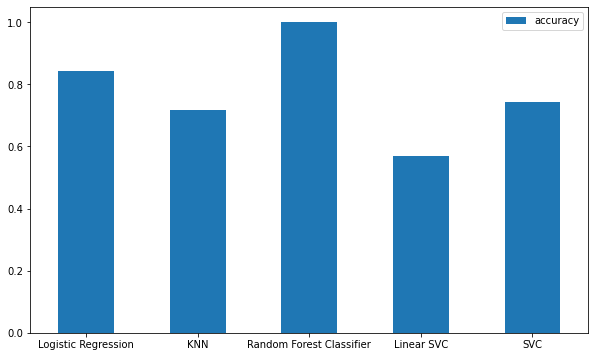

In [17]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar(figsize=(10, 6), rot=0);
model_scores


## It looks like the Random Forest is overfitting so we will tune the Logistic Regression model

To tune the Logistic regression hyperparameters, we will use Grid Search CV

In [18]:
# Create a dictionary with hyperparams as keys and values as values
log_reg_grid = {
                'penalty': ['l1', 'l2'],
                'C': np.logspace(-8, 8, 100),
                'solver': ['liblinear']
               }

# Instantiate the GridSearchCV
gs_log_reg = GridSearchCV(LogisticRegression(random_state=42),
                          param_grid=log_reg_grid,
                          cv=10,
                          verbose=True,
                          n_jobs=-1)

gs_log_reg.fit(X_train, y_train)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   14.7s finished


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.00000000e-08, 1.45082878e-08, 2.10490414e-08, 3.05385551e-08,
       4.43062146e-08, 6.42807312e-08, 9.32603347e-08, 1.35304777e-07,
       1.96304065e-07, 2.84803587e-07, 4.13201240e-07, 5.99484250e-07,
       8.69749003e-07, 1.26185688e-06, 1.83073828e-06, 2.65608778e-06,
       3.85352859e-...
       8.49753436e+04, 1.23284674e+05, 1.78864953e+05, 2.59502421e+05,
       3.76493581e+05, 5.46227722e+05, 7.92482898e+05, 1.14975700e+06,
       1.66810054e+06, 2.42012826e+06, 3.51119173e+06, 5.09413801e+06,
       7.39072203e+06, 1.07226722e+07, 1.55567614e+07, 2.25701972e+07,
       3.27454916e+07, 4.75081016e+07, 6.89261210e+07, 1.00000000e+08]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=True)

In [19]:
# Check the best combination of hyperparams
gs_log_reg.best_params_

{'C': 1.2045035402587836, 'penalty': 'l2', 'solver': 'liblinear'}

In [20]:
# Train a new Logistic Regression model with the best params for GridSearchCV
tuned_log_reg = LogisticRegression(C=1.2045035402587836, penalty='l2', solver='liblinear', random_state=42, n_jobs=-1)
tuned_log_reg.fit(X_train, y_train)
tuned_log_reg.score(X_test, y_test)

0.8421052631578947